In [43]:
# Generic
import html
import os
from pathlib import Path
import typing
import json
import os
from pathlib import Path
import typing
import html
import copy

# Transformers
import circuitsvis
from circuitsvis.attention import attention_heads
from circuitsvis.tokens import colored_tokens_multi
import matplotlib.pyplot as plt

# Numerical Computing
import numpy as np
import torch
import pandas as pd
from jaxtyping import Float, Int

# Utilities
from muutils.statcounter import StatCounter
from muutils.json_serialize import serializable_dataclass, SerializableDataclass, serializable_field

# Our Code
from maze_transformer.utils.notebook_utils import configure_notebook
from maze_transformer.generation.lattice_maze import LatticeMaze, SolvedMaze
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.dataset.tokenizer import SPECIAL_TOKENS, HuggingMazeTokenizer
from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer
from maze_transformer.evaluation.plot_maze import MazePlot, PathFormat
from maze_transformer.evaluation.eval_model import load_model_with_configs
from maze_transformer.utils.token_utils import tokens_to_coords
from maze_transformer.dataset.maze_dataset import MazeDataset, MazeDatasetConfig
from maze_transformer.dataset.maze_dataset_configs import MAZE_DATASET_CONFIGS


def pprint_summary(summary: dict):
	print(json.dumps(summary, indent=2))

In [2]:
# Setup
DEVICE = configure_notebook(seed=42, dark_mode=True)
PATH_EXAMPLES: Path = Path("../examples/")
PATH_DATA: Path = Path("../data/")

# We won't be training any models
torch.set_grad_enabled(False)

MODEL_PATH: Path = PATH_EXAMPLES / "multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02/model.final.zanj"
print(f"will try to get model from {MODEL_PATH.as_posix()}")

# get the default model from examples
MODEL: ZanjHookedTransformer = ZanjHookedTransformer.read(MODEL_PATH)
print(f"loaded model: {MODEL.zanj_model_config.name} with {MODEL.num_params()} parameters")

# generate a smaller test dataset
DATASET_TEST_CFG: MazeDatasetConfig = copy.deepcopy(MODEL.zanj_model_config.dataset_cfg)
DATASET_TEST_CFG.n_mazes = 100
DATASET_TEST: MazeDataset = MazeDataset.from_config(
    DATASET_TEST_CFG,
    local_base_path=PATH_DATA,
    verbose=True,
)
print(f"got test dataset: {DATASET_TEST.cfg.name} with {len(DATASET_TEST)} mazes")

will try to get model from ../examples/multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02/model.final.zanj
loaded model: multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1 with 70319 parameters
loading dataset from ../data/demo-g6-n100-a_dfs-h88923.zanj
Got dataset demo with 100 items. output.cfg.to_fname() = 'demo-g6-n100-a_dfs-h88923'
got test dataset: demo with 100 mazes


In [47]:
@serializable_dataclass
class ProcessedMazeAttention(SerializableDataclass):
    input_maze: SolvedMaze
    tokens: list[str]
    maze_only_tokens: list[str]
    logits: Float[torch.Tensor, "n_vocab"]
    n_layers: int
    n_heads: int
    attention_dict: dict[str, Float[torch.Tensor, "1 n_heads n_positions n_positions"]]
    attention_tensored: Float[torch.Tensor, "n_layers n_heads n_tokens n_tokens"]
    attention_names: list[str] # names for attention_tensored

    def plot_attentions(self):
        return attention_heads(
            self.attention_tensored, 
            self.maze_only_tokens, 
            self.attention_names,
        )
    
    def summary(self) -> dict:
        return {
            "tokens": " ".join(self.tokens),
            "maze_only_tokens": " ".join(self.maze_only_tokens),
            "n_layers": self.n_layers,
            "n_heads": self.n_heads,
            "logits.shape": self.logits.shape,
            "attention_tensored.shape": self.attention_tensored.shape,
            "attention_names": " ".join(self.attention_names),
            "attention_dict.keys()": " ".join(list(self.attention_dict.keys())),
        }
    
    @classmethod
    def from_model_and_dataset(
        cls,
        model: ZanjHookedTransformer,
        dataset: MazeDataset,
        n_mazes: int = 1,
    ) -> list["ProcessedMazeAttention"]:

        outputs: list[ProcessedMazeAttention] = list()


        for i in range(n_mazes):
            
            # get the maze from the dataset and process into tokens
            solved_maze: SolvedMaze = dataset[i]
            tokens: list[str] = solved_maze.as_tokens(dataset.cfg.node_token_map)
            path_start_index: int = tokens.index(SPECIAL_TOKENS["path_start"])
            maze_only_tokens: list[str] = tokens[:path_start_index + 1]

            # get the model's prediction and attention data
            with torch.no_grad():
                # we have to join here, since otherwise run_with_cache assumes each token is a separate batch
                logits, cache = model.run_with_cache(' '.join(maze_only_tokens))

            # filter and append to outputs
            attention_data: dict[str, torch.Tensor] = {
                k:w 
                for k, w in cache.items() 
                if 'hook_pattern' in k
            }

            assert model.zanj_model_config.model_cfg.n_layers == len(attention_data)
            example_attention_data: Float[torch.Tensor, "1 n_heads n_positions n_positions"] = attention_data[list(attention_data.keys())[0]]
            assert model.zanj_model_config.model_cfg.n_heads == example_attention_data.shape[1]
            n_tokens: int = example_attention_data.shape[2]

            attention_tensored: Float[torch.Tensor, "n_layers_heads n_tokens n_tokens"] = torch.concatenate(
                [w for k,w in attention_data.items()],
                dim=0,
            ).reshape(-1, n_tokens, n_tokens)
            
            outputs.append(ProcessedMazeAttention(
                input_maze=solved_maze,
                tokens=tokens,
                maze_only_tokens=maze_only_tokens,
                logits=logits,
                n_layers=model.zanj_model_config.model_cfg.n_layers,
                n_heads=model.zanj_model_config.model_cfg.n_heads,
                attention_dict=attention_data,
                attention_tensored=attention_tensored,
                attention_names=[
                    f"Layer {i} Head {j}" 
                    for i in range(model.zanj_model_config.model_cfg.n_layers) 
                    for j in range(model.zanj_model_config.model_cfg.n_heads)
                ],
            ))

        return outputs
    
    def plot_colored_tokens_multi(self, from_token: int = 0):
        attentions_from_token: Float[torch.Tensor, "n_tokens-from_token n_layers_heads"] = torch.sum(
            self.attention_tensored[:, from_token+1:, from_token+1:],
            dim=2,
        ).T
        print(f"{attentions_from_token.shape = }")
        return colored_tokens_multi(self.maze_only_tokens[from_token:], attentions_from_token, self.attention_names)

{
  "name": "tiny-v1",
  "act_fn": "gelu",
  "d_model": 32,
  "d_head": 16,
  "n_layers": 4,
  "weight_processing": {
    "are_layernorms_folded": false,
    "are_weights_processed": true
  },
  "n_heads": 2
}
{
  "tokens": "<ADJLIST_START> (3,5) <--> (4,5) ; (4,2) <--> (4,1) ; (4,5) <--> (5,5) ; (4,1) <--> (4,0) ; (1,0) <--> (2,0) ; (1,5) <--> (0,5) ; (1,4) <--> (1,5) ; (0,2) <--> (0,1) ; (0,3) <--> (0,4) ; (5,0) <--> (5,1) ; (4,0) <--> (5,0) ; (0,3) <--> (0,2) ; (3,2) <--> (3,1) ; (2,3) <--> (1,3) ; (0,2) <--> (1,2) ; (2,2) <--> (1,2) ; (4,3) <--> (3,3) ; (0,4) <--> (1,4) ; (4,3) <--> (4,4) ; (3,1) <--> (2,1) ; (4,2) <--> (4,3) ; (5,1) <--> (5,2) ; (3,0) <--> (2,0) ; (5,4) <--> (5,3) ; (5,4) <--> (5,5) ; (0,0) <--> (0,1) ; (2,5) <--> (1,5) ; (1,0) <--> (1,1) ; (5,3) <--> (5,2) ; (2,4) <--> (2,3) ; (1,0) <--> (0,0) ; (3,3) <--> (3,2) ; (2,4) <--> (2,5) ; (3,4) <--> (3,5) ; (2,2) <--> (2,1) ; <ADJLIST_END> <ORIGIN_START> (2,5) <ORIGIN_END> <TARGET_START> (2,1) <TARGET_END> <PATH_START>

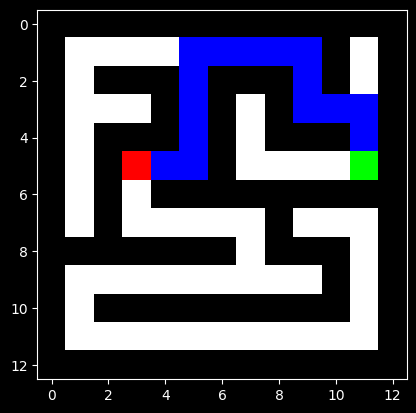

In [48]:
ATTENTION_DATA: ProcessedMazeAttention = ProcessedMazeAttention.from_model_and_dataset(
	model=MODEL, dataset=DATASET_TEST, n_mazes=1,
)[0]

pprint_summary(MODEL.zanj_model_config.model_cfg.summary())
pprint_summary(ATTENTION_DATA.summary())

plt.imshow(ATTENTION_DATA.input_maze.as_pixels())

# ATTENTION_DATA.plot_attentions()

ATTENTION_DATA.plot_colored_tokens_multi()

In [ ]:
def prediction_contained_a_coordinate_token(tokens: list[str], tokenizer: HuggingMazeTokenizer) -> bool:
	"""Check if the prediction contains a coordinate token"""
	for t in tokens:
		if t not in list(tokenizer.special_tokens_map.values()) + tokenizer.additional_special_tokens:
			return True
	print("FAIL: Sampled a path - No coordinate token found before EOS")
	return False

predicted_tokens = []
while not prediction_contained_a_coordinate_token(predicted_tokens, model.tokenizer):
	predictions = model.generate(array_tensor, max_new_tokens=50, stop_at_eos=True, verbose=False)
	predicted_tokens = model.to_str_tokens(predictions)[len(maze_only_tokens):]
print("SUCCESS: Model predicted the path:")
print(predicted_tokens)

path_predicted: list[tuple[int,int]] = tokens_to_coords(
	predicted_tokens,
	maze_data_cfg = cfg.dataset_cfg, 
	when_noncoord = "skip",
)

# plot the maze and both solutions
# for label, fmt, color, path in paths
MazePlot(maze).add_true_path(path_true).add_predicted_path(path_predicted).plot()
plt.show()